In [158]:
using LinearAlgebra
using Random
using Statistics
using Plots

In [159]:
# Função QR via decomposição de Householder nativa do Julia
function qr_(A)
    F = qr(A)

    Q = Matrix(F.Q)   # matriz Q construída com Householder
    R = F.R           # matriz triangular superior
    return Q, R
end



qr_ (generic function with 1 method)

In [160]:
# Função QR via Gram-Schmidt clássico
function gram_schmidt_qr(A)
    m, n = size(A)
    Q = zeros(Float64, m, n)
    R = zeros(Float64, n, n)

    for j in 1:n
        v = A[:, j]
        for i in 1:j-1
            R[i, j] = Q[:, i]' * A[:, j]
            v -= R[i, j] * Q[:, i]
        end
        R[j, j] = norm(v)
        Q[:, j] = v / R[j, j]
    end
    return Q, R
end

gram_schmidt_qr (generic function with 1 method)

In [161]:
# Função QR via Householder artesanal, seguindo o algoritmo clássico que pode ser aplicado na mão
function householder_qr(A)
    m, n = size(A)
    R = copy(A)  # R vai ser transformada em matriz triangular superior
    Q = Matrix{Float64}(I, m, m)  # Começa como identidade, vai acumulando as reflexões

    for k = 1:min(m - 1, n)
        # 1. Extraímos o vetor da coluna atual a partir da linha k
        x = R[k:end, k]

        # 2. Criamos o vetor v da reflexão de Householder
        e1 = zeros(length(x))
        e1[1] = 1.0
        v = x + sign(x[1]) * norm(x) * e1
        v /= norm(v)

        # 3. Construímos a matriz de reflexão Hk (compacta)
        Hk = Matrix{Float64}(I, m, m)
        Hk[k:end, k:end] .-= 2 * (v * v')   # Atualiza só a submatriz

        # 4. Aplica Hk a R (Hk * R)
        R = Hk * R

        # 5. Acumula a transformação em Q
        Q = Q * Hk
    end

    return Q, R
end


householder_qr (generic function with 1 method)

In [162]:
# Função que executa uma das três versões de QR e imprime os resultados dos erros
function Print_resultados(A, Q, R)
    m, n = size(A)
    
    println("Matriz Q:", Q)
    println("Matriz R:", R)

    # Erro relativo da decomposição (QR ≈ A)
    erro_qr = norm(Q * R - A) / norm(A)

    # Verificação de ortogonalidade (QᵗQ ≈ I)
    erro_ortogonalidade = norm(Matrix(I, m, m) - Q' * Q)

    # Verificação de triangularidade superior de R (parte inferior ≈ 0)
    R_lower = tril(R, -1)  # Pega a parte estritamente inferior
    erro_triangularidade = norm(R_lower) / norm(R)  # Erro relativo

    # Erro de máquina
    ϵ = eps(Float64)

    # Resultados
    println("Erro relativo QR ≈ A:", erro_qr)
    println("Erro de ortogonalidade QᵗQ ≈ I:", erro_ortogonalidade)
    println("Erro de triangularidade R:", erro_triangularidade)
    println("Erro da máquina: ", ϵ)

    println("\nQR é preciso? ", erro_qr < ϵ * 100)
    println("Q é ortogonal? ", erro_ortogonalidade < ϵ * 100)
    println("R é triangular superior? ", erro_triangularidade < ϵ * 100)
    println("\n======================================== \n")
end

Print_resultados (generic function with 1 method)

In [163]:
# Aplicar QR pela função do pacote LinearAlgebra
A=rand(3, 3) # matriz aleatória 3x3
Q, R = qr_(A)
Print_resultados(A,Q,R)

# Aplicar QR via Gram-Schmidt
Qg, Rg = gram_schmidt_qr(A)
Print_resultados(A,Qg,Rg)

# QR Decomposition using Householder reflections
Qh, Rh = householder_qr(A)
Print_resultados(A,Qh,Rh)

Matriz Q:[-0.9027131256004537 0.32892361279468596 0.27734143183944043; -0.4161159800378922 -0.5036413873722949 -0.7570950033402772; -0.10934580022005431 -0.7988457985567686 0.5915140624722581]
Matriz R:[-0.9153820346155913 -0.9463385089894093 -0.43313220187884977; 0.0 -1.0407057555842447 -1.0011820934744866; 0.0 0.0 -0.1299750720867895]
Erro relativo QR ≈ A:1.5674275383669732e-16
Erro de ortogonalidade QᵗQ ≈ I:1.8515278288508872e-16
Erro de triangularidade R:0.0
Erro da máquina: 2.220446049250313e-16

QR é preciso? true
Q é ortogonal? true
R é triangular superior? true


Matriz Q:[0.9027131256004537 -0.328923612794686 -0.2773414318394392; 0.41611598003789213 0.503641387372295 0.7570950033402751; 0.10934580022005431 0.7988457985567688 -0.5915140624722613]
Matriz R:[0.9153820346155914 0.9463385089894093 0.4331322018788497; 0.0 1.0407057555842445 1.0011820934744868; 0.0 0.0 0.12997507208678943]
Erro relativo QR ≈ A:5.534940806276136e-17
Erro de ortogonalidade QᵗQ ≈ I:5.759064573199494e-15

In [175]:
# Função para gerar uma matriz de tamanho m x m com número de condição desejado usando SVD
function generate_any_conditioned_matrix(m, desired_condition_number)
    # Gera duas matrizes ortogonais U e V a partir de QR de matrizes aleatórias
    U, _ = qr(randn(m, m))
    V, _ = qr(randn(m, m))

    # Cria os valores singulares de forma decrescente, de 1 até 1/desired_condition_number
    # Usamos uma escala logarítmica para distribuir os valores singulares
    singular_values = exp.(range(0, -log(desired_condition_number), length=m))
    D = Diagonal(singular_values)

    # Monta a matriz mal condicionada: A = U * D * Vᵀ 
    A = U * D * V'

    return A
end

# Função para testar sensibilidade
function plot_sensitivity(cond_good, cond_bad; N=50)
    n = 10
    A_good = generate_any_conditioned_matrix(n, cond_good)
    A_bad = generate_any_conditioned_matrix(n, cond_bad)

    x_real = ones(n)
    b_good = A_good * x_real
    b_bad = A_bad * x_real

    epsilons = range(1e-10, 0.10, length=100)
    errors_good = Float64[]
    errors_bad = Float64[]

    for eps in epsilons
        temp_errors_good = []
        temp_errors_bad = []

        for _ in 1:N
            δb = eps * randn(n)

            x_good = A_good \ (b_good + δb)
            x_bad = A_bad \ (b_bad + δb)

            push!(temp_errors_good, norm(x_good - x_real) / norm(x_real))
            push!(temp_errors_bad, norm(x_bad - x_real) / norm(x_real))
        end

        push!(errors_good, mean(temp_errors_good))
        push!(errors_bad, mean(temp_errors_bad))
    end

    plot(epsilons, errors_good, label="Bem Condicionado", lw=2, color=:blue, yscale=:log10)
    plot!(epsilons, errors_bad, label="Mal Condicionado", lw=2, ls=:dash, color=:red)

    xlabel!("Magnitude da Perturbação na Entrada (ε)")
    ylabel!("Erro na Saída (Δx)")
    title!("Sensibilidade a Perturbações na Entrada")
end




plot_sensitivity (generic function with 1 method)

In [195]:
# Testando a função de plotagem com uma matriz 7x7 e número de condição 1 ate 10^10
for k in 10 .^(0:10) 
    A = generate_any_conditioned_matrix(7, k)
    println("Número condicional: ", cond(A))
end    
    


Número condicional: 1.0000000000000009
Número condicional: 10.00000000000002
Número condicional: 100.00000000000003
Número condicional: 1000.0000000000075
Número condicional: 9999.999999995955
Número condicional: 99999.99999992529
Número condicional: 999999.9999470925
Número condicional: 1.000000000002135e7
Número condicional: 9.999999984867562e7
Número condicional: 9.99999982597644e8
Número condicional: 1.0000000244090813e10


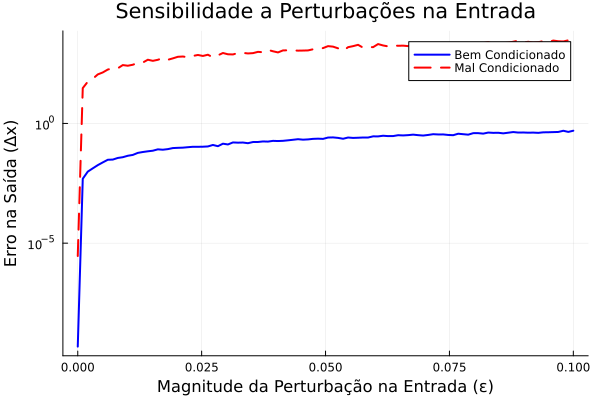

In [191]:
# Gerar o gráfico
plot_sensitivity(10, 1e5)

In [59]:
# Função para registrar erros de QR em vetores globais (Print_resultados em larga escala)
function registrar_erros_qr(A, Q, R, id_alg, c)
    m, n = size(A)

    # Erro relativo da decomposição (QR ≈ A)
    erro_qr = norm(Q * R - A) / norm(A)

    # Verificação de ortogonalidade (QᵗQ ≈ I)
    erro_ortogonalidade = norm(Matrix(I, m, m) - Q' * Q)

    # Verificação de triangularidade superior de R (parte inferior ≈ 0)
    R_lower = tril(R, -1)  # Pega a parte estritamente inferior
    erro_triangularidade = norm(R_lower) / norm(R)  # Erro relativo

    # Erro de máquina
    ϵ = eps(Float64)

    # Atualiza vetores globais
    global qr_errors[id_alg] += erro_qr > ϵ * c
    global q_ortho_errors[id_alg] += erro_ortogonalidade > ϵ * c
    global r_triang_errors[id_alg] += erro_triangularidade > ϵ * c
end


# Função para plotar os erros das 3 implementacões de QR simulando N execuções com uma matriz de condição específica 
function plot_error(N, m, k, c)
    # Vetores globais de contagem
    global qr_errors = [0, 0, 0]
    global q_ortho_errors = [0, 0, 0]
    global r_triang_errors = [0, 0, 0] 

    # Loop de N execuções para cada método
    for i in 1:N
        A = generate_any_conditioned_matrix(m, k)

        # Método 1: QR de Julia (Householder interno)
        Q1, R1 = qr_(A)
        registrar_erros_qr(A, Q1, R1, 1, c)

        # Método 2: Gram-Schmidt
        Q2, R2 = gram_schmidt_qr(A)
        registrar_erros_qr(A, Q2, R2, 2, c)

        # Método 3: Householder implementado manualmente
        Q3, R3 = householder_qr(A)
        registrar_erros_qr(A, Q3, R3, 3, c)
    end

    # Função para formatar a saída com contagem e porcentagem
    function format_error(count)
        percentage = round(count / N * 100, digits=2)
        return "$count ($percentage%)"
    end

    # Exibe os resultados após as execuções
    println("Erros QR (decomposição ≠ A) em $N execuções:")
    println("QR padrão:        ", format_error(qr_errors[1]))
    println("Gram-Schmidt:     ", format_error(qr_errors[2]))
    println("Householder:      ", format_error(qr_errors[3]))

    println("\nErros de ortogonalidade (QᵗQ ≠ I) em $N execuções:")
    println("QR padrão:        ", format_error(q_ortho_errors[1]))
    println("Gram-Schmidt:     ", format_error(q_ortho_errors[2]))
    println("Householder:      ", format_error(q_ortho_errors[3]))

    println("Erros de triangularidade (R não é triangular) em $N execuções:")
    println("QR padrão:        ", format_error(r_triang_errors[1]))
    println("Gram-Schmidt:     ", format_error(r_triang_errors[2]))
    println("Householder:      ", format_error(r_triang_errors[3]))

    # Plotando os gráficos dos erros

    # Erros de decomposição (QR ≠ A)
    bar1 = bar([qr_errors[1], qr_errors[2], qr_errors[3]], label=["QR padrão", "Gram-Schmidt", "Householder"], title="Erros QR (decomposição ≠ A)", ylabel="Erro", xlabel="Métodos")

    # Erros de ortogonalidade (QᵗQ ≠ I)
    bar2 = bar([q_ortho_errors[1], q_ortho_errors[2], q_ortho_errors[3]], label=["QR padrão", "Gram-Schmidt", "Householder"], title="Erros de Ortogonalidade (QᵗQ ≠ I)", ylabel="Erro", xlabel="Métodos")

    # Erros de triangularidade (R não é triangular)
    bar3 = bar([r_triang_errors[1], r_triang_errors[2], r_triang_errors[3]], label=["QR padrão", "Gram-Schmidt", "Householder"], title="Erros de Triangularidade (R não é triangular)", ylabel="Erro", xlabel="Métodos")

    # Exibe os gráficos
    plot(bar1, bar2, bar3, layout=(3, 1), size=(1200, 900))
end

plot_error (generic function with 1 method)

Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     21923 (21.92%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)


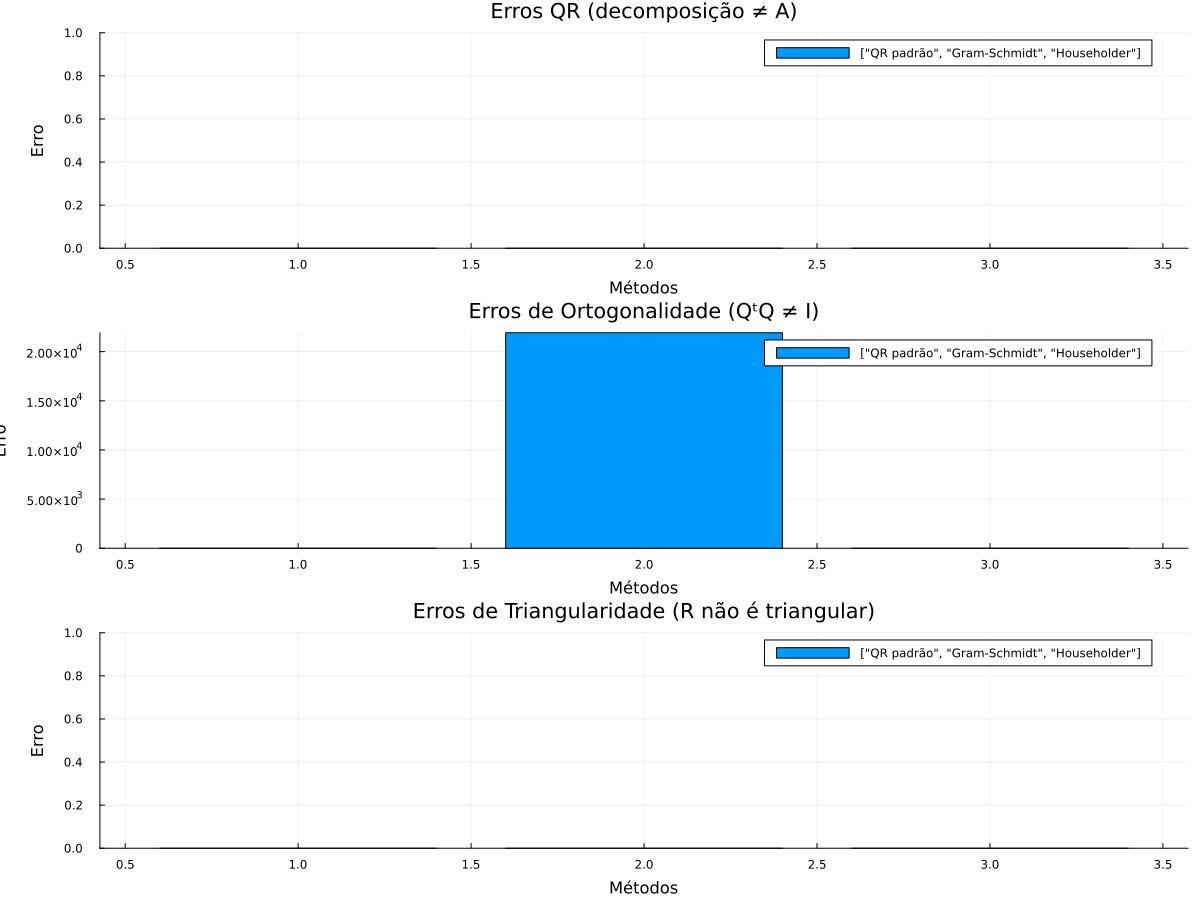

In [60]:
# Executando a função de plotagem com 100000 execuções, matriz 3x3 e número de condição 100(bem condicionada)
plot_error(100000, 3, 100, 100)

Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     57932 (57.93%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)


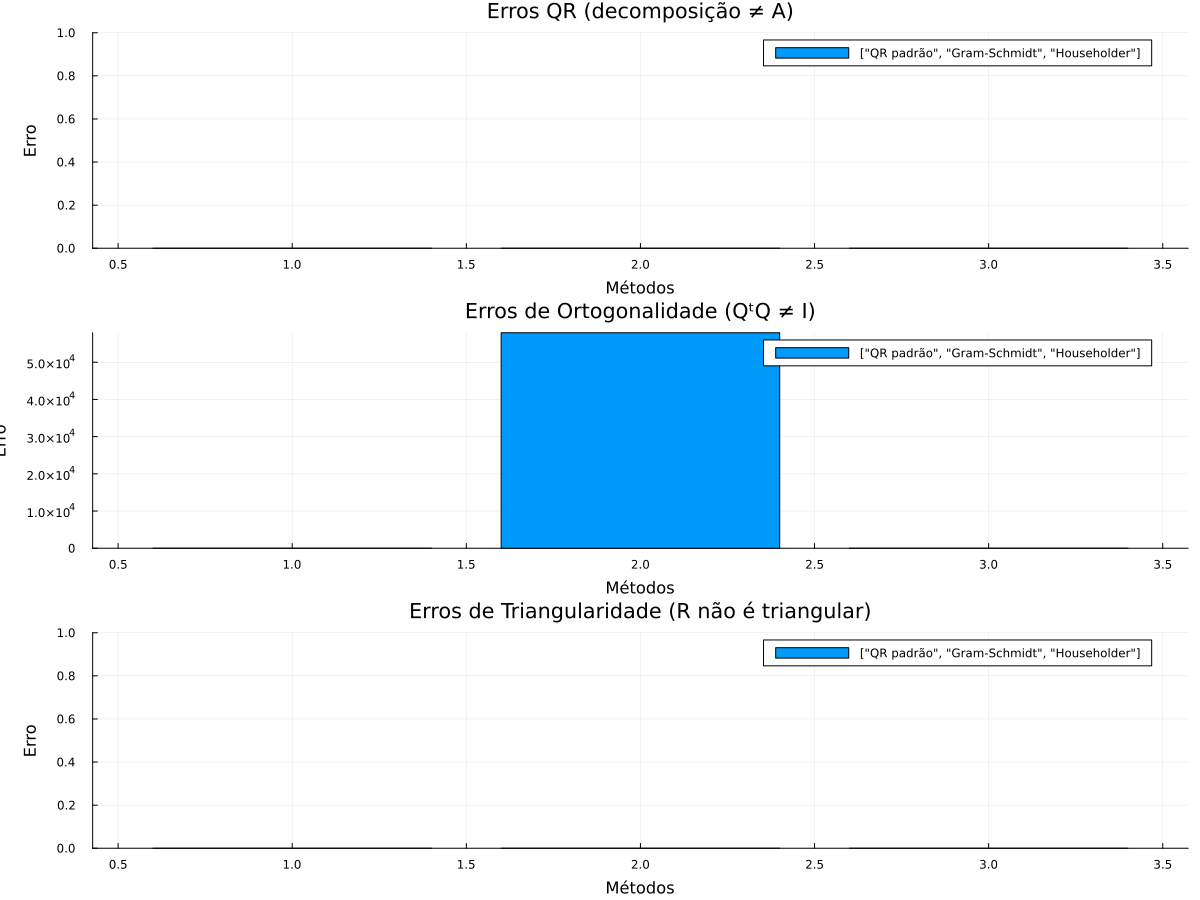

In [61]:
plot_error(100000, 5, 100, 100)


In [204]:
# Função para analisar o erro de ortogonalidade em diferentes dimensões
function analyze_orthogonality_error(N, max_dim, k, c)
    dims = 2:max_dim
    n = length(dims)

    errors_qr = zeros(n)
    errors_gs = zeros(n)
    errors_hh = zeros(n)
    
    for (i, d) in enumerate(dims)
        global q_ortho_errors = [0, 0, 0]
        
        plot_error(N, d, k, c)
        
        errors_qr[i] = q_ortho_errors[1] / N * 100
        errors_gs[i] = q_ortho_errors[2] / N * 100
        errors_hh[i] = q_ortho_errors[3] / N * 100
        
        println("Dimensão $d concluída")
    end
    
    p = plot(dims, hcat(errors_qr, errors_gs, errors_hh), 
             label=["QR Padrão" "Gram-Schmidt" "Householder"],
             xlabel="Dimensão da Matriz", 
             ylabel="Porcentagem de Erro de Ortogonalidade (%)",
             title="Evolução do Erro de Ortogonalidade por Dimensão\ncom c = $(c) e cond(A) = $(k)",
             linewidth=2,
             markershape=:circle,
             markersize=4,
             legend=:topleft)
    
    display(p)
end



analyze_orthogonality_error (generic function with 2 methods)

Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     768 (0.77%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Dimensão 2 concluída
Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        3 (0.0%)
Gram-Schmidt:     2391 (2.39%)
Householder:      14 (0.01%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Dimensão 3 concluída
Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:    

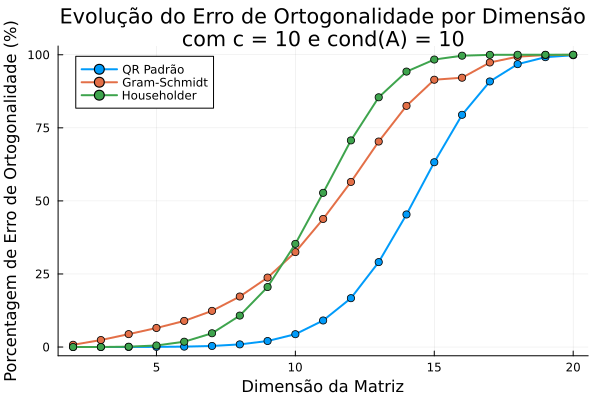

In [ ]:
#testando a função de análise de erro de ortogonalidade com matrizes muito bem condicionadas e c = 10 para evidenciar os erros
analyze_orthogonality_error(100000, 20, 10, 10)

Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Dimensão 2 concluída
Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Dimensão 3 concluída
Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%

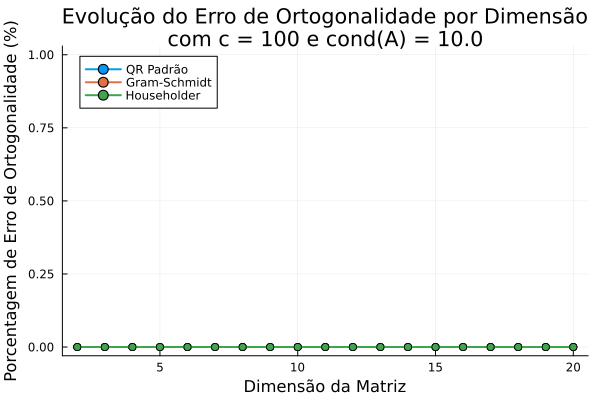

In [ ]:
#testando a função de análise de erro de ortogonalidade com matrizes bem condicionadas e c ajustado para o padrão de erro no julia (c igual nos proximos testes)
analyze_orthogonality_error(100000, 20, 1e1, 100)

Neste primeiro teste com matrizes muito bem condicionadas (k=10), percebemos que o erro de ortogonalidade permanece "nulo" para todos os algoritimos em todas dimensões

Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     798 (0.8%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Dimensão 2 concluída
Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     22225 (22.22%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Dimensão 3 concluída
Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:     

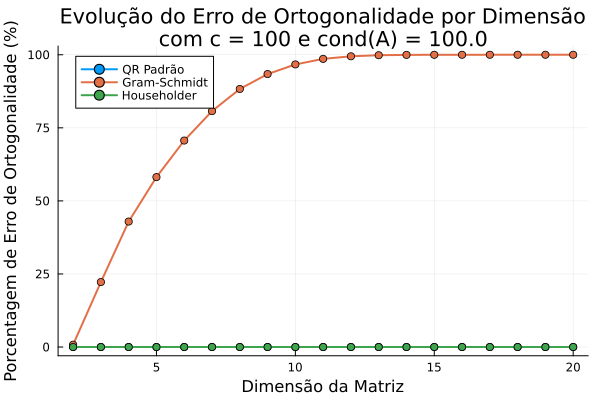

In [ ]:
#testando a função de análise de erro de ortogonalidade com matrizes menos bem condicionadas 
analyze_orthogonality_error(100000, 20, 1e2, 100)

Neste segundo teste com matrizes bem condicionadas (k=100), percebemos que o erro de ortogonalidade permanece "nulo" apenas para os householders em todas dimensões, e é gradualmente crescente para o gram-Schmidt, que não é estável.

Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     62864 (62.86%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Dimensão 2 concluída
Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     92533 (92.53%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Dimensão 3 concluída
Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder: 

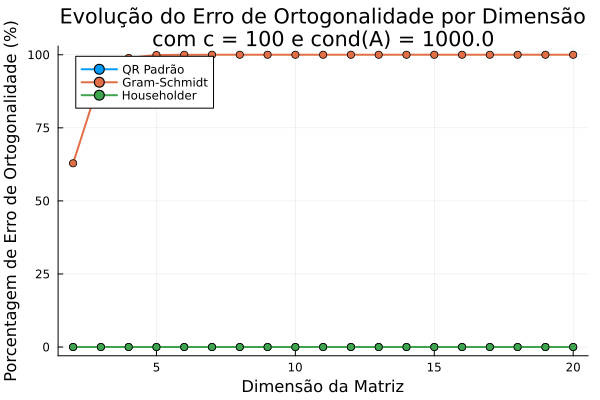

In [ ]:
#testando a função de análise de erro de ortogonalidade com matrizes mau condicionadas 
analyze_orthogonality_error(100000, 20, 1e3, 100)

Neste teste com matrizes mal condicionadas (k=1000), percebemos resultado semelhante ao anterior, com um agravante no erro do Gram-Schmidt, que se estaguina perto do 100% muito mais cedo, já tendo um erro elevado mesmo em dimensões menores.

Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     100000 (100.0%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Dimensão 2 concluída
Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     100000 (100.0%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Dimensão 3 concluída
Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder

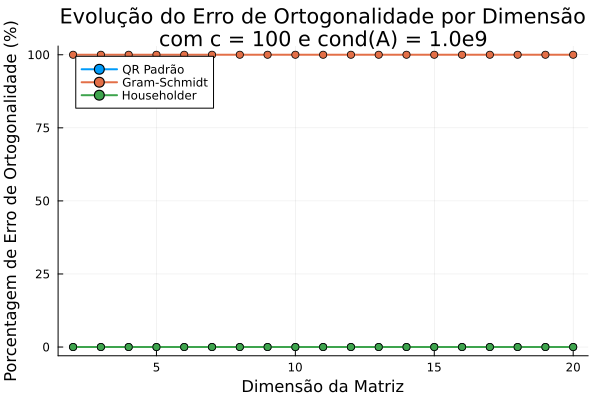

In [ ]:
#testando a função de análise de erro de ortogonalidade com matrizes péssimamente condicionadas
analyze_orthogonality_error(100000, 20, 1e9, 100)

Neste último teste com matrizes péssimamente condicionadas (k=10^9), temos o resultado com mais destaque da diferença ente um algoritimo não estável e um backward stable. Gram-Schmidt desde a dimensão 2 ja apresenta praticamente 100% de erro nas 100000 execuções. E mesmo com matrizes tão mau condicionadas, os householders (nativo do julia e o implementado por nós), continuam mostrando erro mínimo. 

Assim confirmando a potência da estabilidade do householder.